<a href="https://colab.research.google.com/github/nigamreetesh84/predict-fraudulent-credit-card-transactions/blob/main/Credit_card_fraud_detection_Starter_code_reetesh_nigam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,
    RandomizedSearchCV, learning_curve, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.calibration import calibration_curve

from imblearn import over_sampling
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"SHAP: {SHAP_AVAILABLE}")
print("="*70)

ENVIRONMENT INFORMATION
Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
XGBoost: 3.1.2
SHAP: True


## Exploratory data analysis

In [2]:
# ============================================================================
# DATASET DIAGNOSTIC & REPAIR TOOL
# ============================================================================


try:
    df = pd.read_csv('/content/sample_data/creditcard.csv')
    print(f"✓ Dataset loaded: {df.shape}")
except Exception as e:
    print(f"❌ ERROR loading dataset: {e}")

df.head()

✓ Dataset loaded: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#observe the different feature type present in the data

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:


# Here we will observe the distribution of our classes
class_counts = df['Class'].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
classes = df['Class'].value_counts()
normal_share = classes[0]/df['Class'].count()*100
fraud_share = classes[1]/df['Class'].count()*100
print(f"\nNormal transactions: {normal_share:.2f}%")
print(f"Fraudulent transactions: {fraud_share:.2f}%")


Normal transactions: 99.83%
Fraudulent transactions: 0.17%


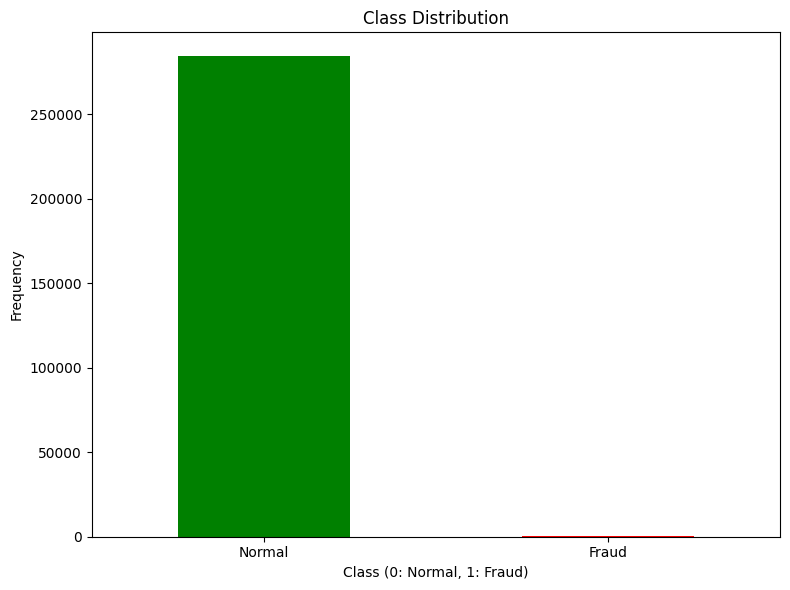

In [6]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transactions
fig, ax = plt.subplots(figsize=(8, 6))
classes.plot(kind='bar', ax=ax, color=['green', 'red'])
ax.set_title('Class Distribution')
ax.set_xlabel('Class (0: Normal, 1: Fraud)')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['Normal', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()


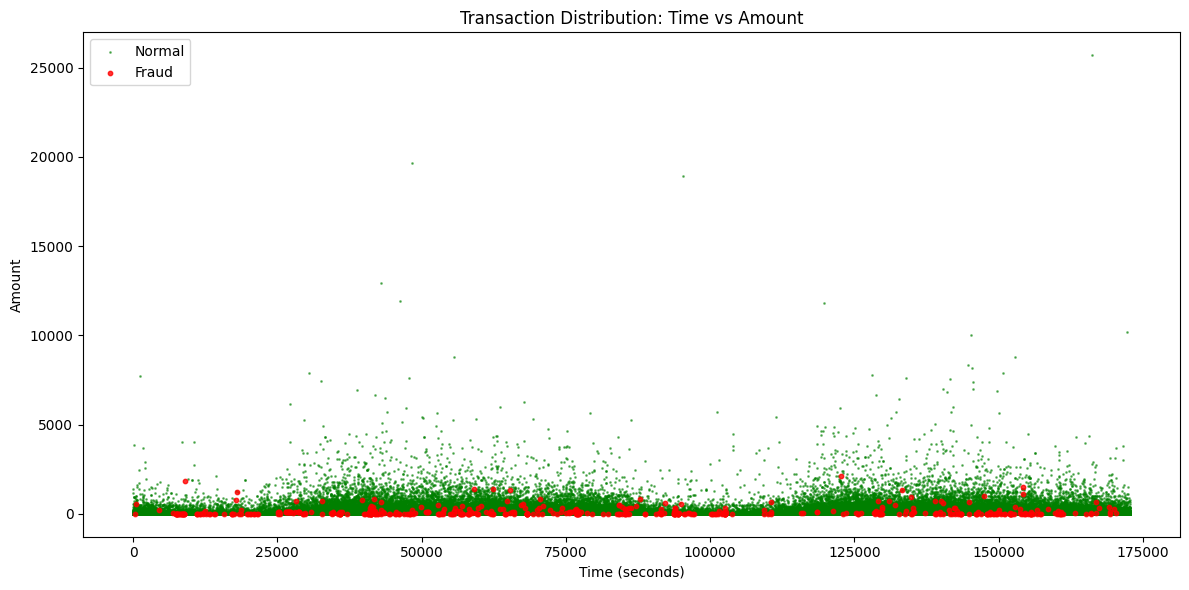

In [7]:
# Create a scatter plot to observe the distribution of classes with time
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df[df['Class']==0]['Time'], df[df['Class']==0]['Amount'],
           alpha=0.5, s=1, label='Normal', c='green')
ax.scatter(df[df['Class']==1]['Time'], df[df['Class']==1]['Amount'],
           alpha=0.8, s=10, label='Fraud', c='red')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amount')
ax.set_title('Transaction Distribution: Time vs Amount')
ax.legend()
plt.tight_layout()
plt.show()

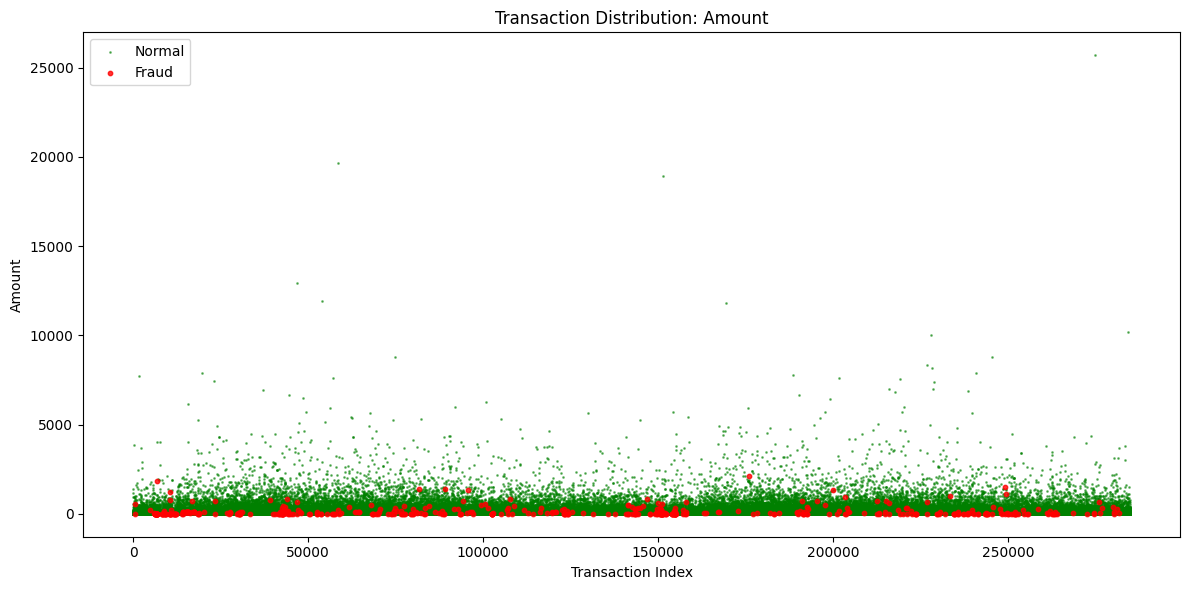

In [8]:
# Create a scatter plot to observe the distribution of classes with Amount
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df[df['Class']==0].index, df[df['Class']==0]['Amount'],
           alpha=0.5, s=1, label='Normal', c='green')
ax.scatter(df[df['Class']==1].index, df[df['Class']==1]['Amount'],
           alpha=0.8, s=10, label='Fraud', c='red')
ax.set_xlabel('Transaction Index')
ax.set_ylabel('Amount')
ax.set_title('Transaction Distribution: Amount')
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# Drop unnecessary columns
print("\nDropping 'Time' column...")
df = df.drop(['Time'], axis=1)
print(f"✓ New shape: {df.shape}")


Dropping 'Time' column...
✓ New shape: (284807, 30)


In [10]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
X = df.drop(['Class'], axis=1)
y = df['Class']
print(f"✓ Features: {X.shape}")
print(f"✓ Target: {y.shape}")

✓ Features: (284807, 29)
✓ Target: (284807,)


In [12]:
print("NaNs in y:", y.isna().sum())
print(y.value_counts(dropna=False))

NaNs in y: 0
Class
0    284315
1       492
Name: count, dtype: int64


In [13]:
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

In [14]:
y = y.astype(int)

In [15]:

#The target variable is verified to contain no missing values before performing stratified sampling

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print(f"\n✓ Train: {X_train.shape[0]} samples ({y_train.sum()} frauds)")
print(f"✓ Test: {X_test.shape[0]} samples ({y_test.sum()} frauds)")




✓ Train: 199364 samples (344 frauds)
✓ Test: 85443 samples (148 frauds)


In [16]:
# Preserve X_test & y_test to evaluate on the test data once you build the model
print(f"\nTotal fraud cases: {np.sum(y)}")
print(f"Train fraud cases: {np.sum(y_train)}")
print(f"Test fraud cases: {np.sum(y_test)}")

print(f"\n✓ Train set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")


Total fraud cases: 492
Train fraud cases: 344
Test fraud cases: 148

✓ Train set: 199364 samples
✓ Test set: 85443 samples


In [17]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
344
148


### Plotting the distribution of a variable

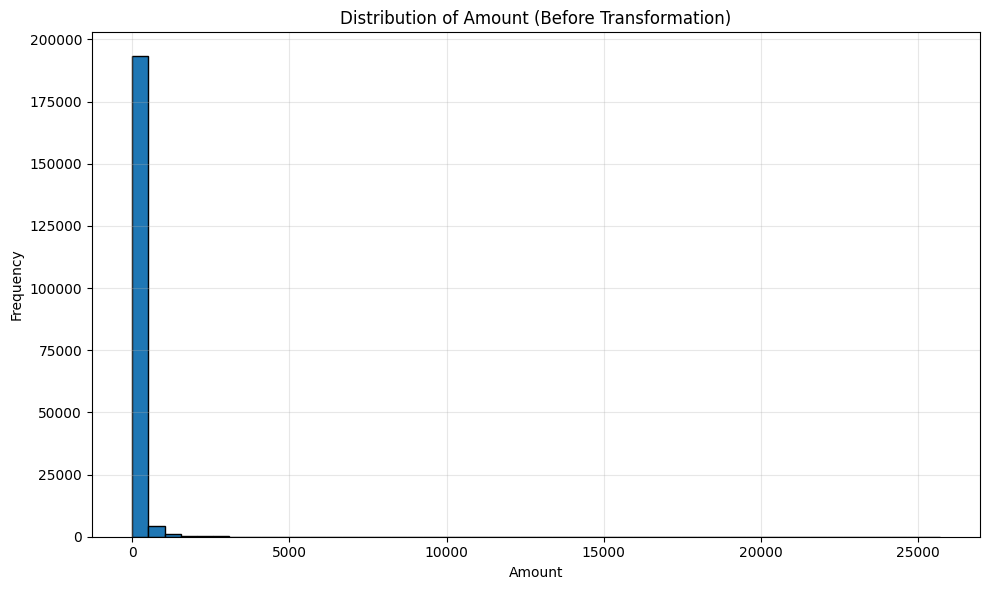

In [18]:
# Plot the histogram of a variable from the dataset to see the skewness
plt.figure(figsize=(10, 6))
plt.hist(X_train['Amount'], bins=50, edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount (Before Transformation)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [19]:
# Apply: preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=False)

# Transform training data
X_train_transformed = pt.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)

# Transform test data
X_test_transformed = pt.transform(X_test)
X_test = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)

print("✓ Power transformation applied")

✓ Power transformation applied


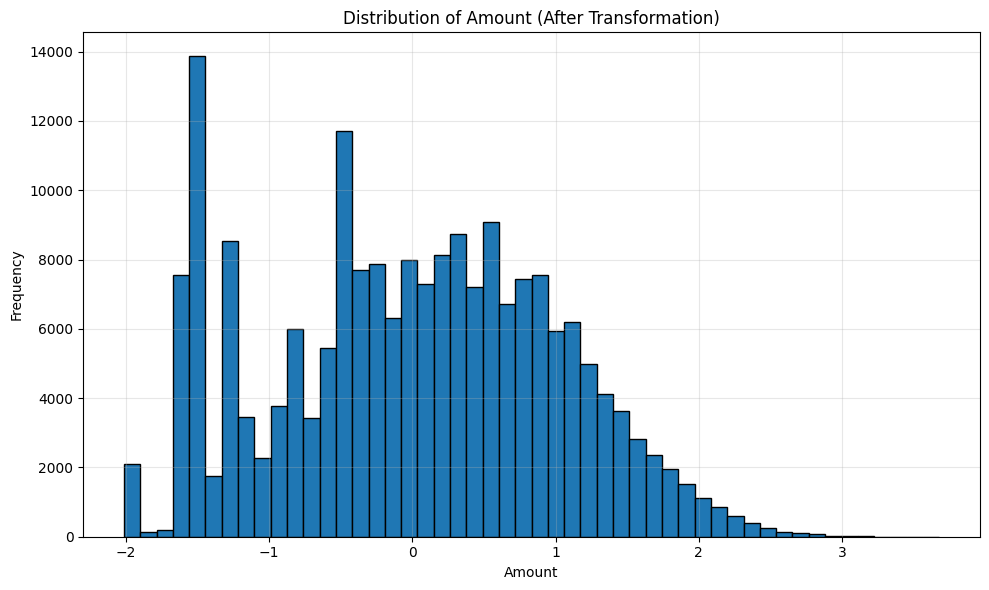

In [20]:
# Plot the histogram of a variable from the dataset again to see the result
plt.figure(figsize=(10, 6))
plt.hist(X_train['Amount'], bins=50, edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount (After Transformation)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# ============================================================================
# SECTION 5: MODEL BUILDING - ULTRA-OPTIMIZED
# ============================================================================


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = 'roc_auc'
N_JOBS = 8  # safer than -1 on Windows

models_imbalanced = {
    'Logistic Regression': {
        'model': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            random_state=RANDOM_STATE,
            max_iter=1000
        ),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l2']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [5], 'weights': ['distance'], 'metric': ['euclidean']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        'params': {'max_depth': [5, 7, 10], 'min_samples_split': [2], 'criterion': ['gini']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=50,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        ),
        'params': {'max_depth': [6, 8], 'max_features': ['sqrt']}
    },
    'XGBoost': {
        'model': XGBClassifier(
            eval_metric='auc',
            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            tree_method="hist"
        ),
        'params': {'max_depth': [3, 5], 'learning_rate': [0.1], 'n_estimators': [100]}
    }
}

print("\nTraining models ...\n")

best_models_imbalanced = {}
imbalanced_results = []

for name, config in models_imbalanced.items():
    print(f"Training {name}...")

    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        search = RandomizedSearchCV(
            config['model'],
            config['params'],
            n_iter=4,
            scoring=scoring,
            cv=cv,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            verbose=0
        )
    else:
        search = GridSearchCV(
            config['model'],
            config['params'],
            scoring=scoring,
            cv=cv,
            n_jobs=N_JOBS,
            verbose=0
        )

    search.fit(X_train, y_train)
    best_models_imbalanced[name] = search.best_estimator_

    imbalanced_results.append({
        'Model': name,
        'Best_Params': str(search.best_params_),
        'CV_ROC_AUC': search.best_score_,
        'CV_Time_Sec': search.refit_time_
    })

    print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}, Time: {search.refit_time_:.2f}s\n")

    import gc
    gc.collect()



Training models ...

Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9823, Time: 3.51s

Training KNN...
  ✓ CV ROC-AUC: 0.9214, Time: 0.12s

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9265, Time: 9.48s

Training Random Forest...
  ✓ CV ROC-AUC: 0.9797, Time: 46.82s

Training XGBoost...
  ✓ CV ROC-AUC: 0.9825, Time: 3.71s



In [22]:

# ============================================================================
# SECTION 6: EVALUATION FUNCTION
# ============================================================================

def evaluate_model_comprehensive(model, X_test, y_test, model_name,
                                  sampling_method='None', threshold=0.5):
    """Comprehensive model evaluation
    Comprehensive evaluation of fraud detection model

    Parameters:
    - model: trained model
    - X_test: test features
    - y_test: test labels
    - model_name: name of the model
    - sampling_method: type of sampling used
    - threshold: classification threshold

    Returns dictionary with performance metrics including:
    - Standard metrics (accuracy, precision, recall, F1)
    - Business metrics (cost, fraud detection rate)
    - Confusion matrix components
    """
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    total_frauds = tp + fn
    total_normal = tn + fp

    return {
        'Model': model_name,
        'Sampling': sampling_method,
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'PR_AUC': average_precision_score(y_test, y_pred_proba),
        'True_Negatives': tn,
        'False_Positives': fp,
        'False_Negatives': fn,
        'True_Positives': tp,
        'Frauds_Detected': tp,
        'Total_Frauds': total_frauds,
        'Fraud_Detection_Rate': tp / total_frauds if total_frauds > 0 else 0,
        'False_Alarm_Rate': fp / total_normal if total_normal > 0 else 0,
        'Total_Cost': (fp * 5) + (fn * 100),
        'Cost_Per_Transaction': ((fp * 5) + (fn * 100)) / len(y_test)
    }

# Evaluate imbalanced models
print("\n" + "="*70)
print("IMBALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_imbalanced = []
for name, model in best_models_imbalanced.items():
    results = evaluate_model_comprehensive(model, X_test, y_test, name, 'Imbalanced')
    test_results_imbalanced.append(results)

test_df_imbalanced = pd.DataFrame(test_results_imbalanced)
key_metrics = ['Model', 'Recall', 'Precision', 'F1_Score', 'ROC_AUC',
               'PR_AUC', 'Frauds_Detected', 'Total_Cost']
print("\n" + test_df_imbalanced[key_metrics].to_string(index=False))


IMBALANCED DATA - TEST EVALUATION

              Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
Logistic Regression 0.878378   0.060748  0.113636 0.970537 0.696743              130       11850
                KNN 0.736486   0.947826  0.828897 0.922182 0.816674              109        3930
      Decision Tree 0.844595   0.054089  0.101667 0.896632 0.466263              125       13230
      Random Forest 0.804054   0.524229  0.634667 0.966723 0.689452              119        3440
            XGBoost 0.851351   0.242308  0.377246 0.971264 0.714454              126        4170



PHASE 2: MODELS ON BALANCED DATA 

Visualizing sampling methods...


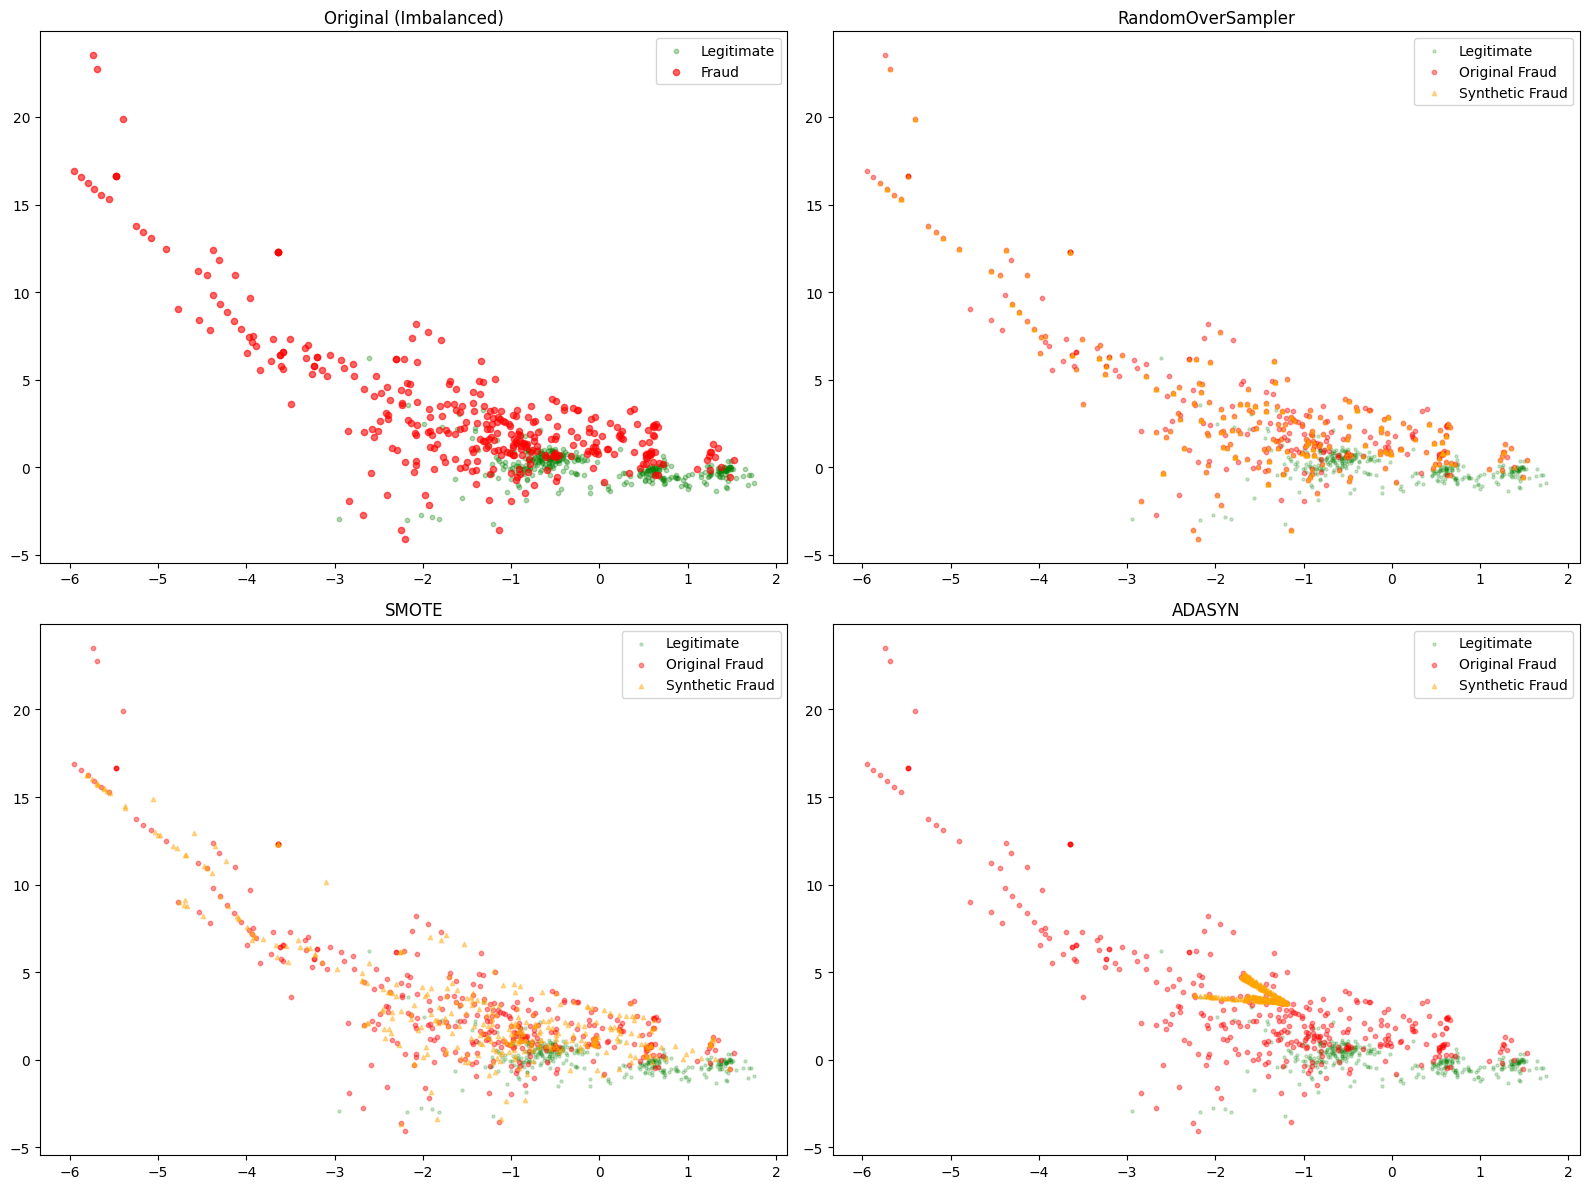

✓ Sampling visualization saved

SAMPLING: RandomOverSampler
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9824

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9291

Training Random Forest...
  ✓ CV ROC-AUC: 0.9754

Training XGBoost...
  ✓ CV ROC-AUC: 0.9687


SAMPLING: SMOTE
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9809

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9562

Training Random Forest...
  ✓ CV ROC-AUC: 0.9824

Training XGBoost...
  ✓ CV ROC-AUC: 0.9699


SAMPLING: ADASYN
Training Logistic Regression...
  ✓ CV ROC-AUC: 0.9785

Training KNN...
  ✓ Trained (no CV for KNN)

Training Decision Tree...
  ✓ CV ROC-AUC: 0.9539

Training Random Forest...
  ✓ CV ROC-AUC: 0.9808

Training XGBoost...
  ✓ CV ROC-AUC: 0.9654


BALANCED DATA - CV RESULTS
         Sampling               Model  CV_ROC_AUC                                                                                       Best_P

In [23]:
# ============================================================================
# SECTION 7: CLASS BALANCING WITH SAMPLING
# ============================================================================

print("\n" + "="*70)
print("PHASE 2: MODELS ON BALANCED DATA ")
print("="*70)

samplers = {
    'RandomOverSampler': over_sampling.RandomOverSampler(random_state=RANDOM_STATE),
    'SMOTE': over_sampling.SMOTE(random_state=RANDOM_STATE),
    'ADASYN': over_sampling.ADASYN(random_state=RANDOM_STATE)
}

print("\nVisualizing sampling methods...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

X_train_1 = X_train[y_train==1].values
X_train_0 = X_train[y_train==0].values
np.random.seed(RANDOM_STATE)
np.random.shuffle(X_train_0)

vis_sample_size = min(500, len(X_train_1))

axes[0,0].scatter(X_train_0[:vis_sample_size, 0], X_train_0[:vis_sample_size, 1],
                  alpha=0.3, s=10, label='Legitimate', c='green')
axes[0,0].scatter(X_train_1[:vis_sample_size, 0], X_train_1[:vis_sample_size, 1],
                  alpha=0.6, s=20, label='Fraud', c='red')
axes[0,0].set_title('Original (Imbalanced)')
axes[0,0].legend()

for idx, (sampler_name, sampler) in enumerate(samplers.items(), 1):
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_synthetic = X_resampled[len(X_train):].values

    synthetic_sample = min(vis_sample_size, len(X_synthetic))  # OPTIMIZED

    axes.flatten()[idx].scatter(X_train_0[:vis_sample_size, 0],
                                X_train_0[:vis_sample_size, 1],
                                alpha=0.2, s=5, label='Legitimate', c='green')
    axes.flatten()[idx].scatter(X_train_1[:vis_sample_size, 0],
                                X_train_1[:vis_sample_size, 1],
                                alpha=0.4, s=10, label='Original Fraud', c='red')
    axes.flatten()[idx].scatter(X_synthetic[:synthetic_sample, 0],
                                X_synthetic[:synthetic_sample, 1],
                                alpha=0.4, s=10, label='Synthetic Fraud',
                                c='orange', marker='^')
    axes.flatten()[idx].set_title(f'{sampler_name}')
    axes.flatten()[idx].legend()

plt.tight_layout()
plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Sampling visualization saved")



N_JOBS = 8

best_models_balanced = {}
balanced_results = []

for sampler_name, sampler in samplers.items():
    print(f"\n{'='*70}")
    print(f"SAMPLING: {sampler_name}")
    print(f"{'='*70}")

    for model_name, config in models_imbalanced.items():
        print(f"Training {model_name}...")

        pipeline = ImbPipeline([
            ('sampler', sampler),
            ('classifier', config['model'])
        ])

        params_pipeline = {f'classifier__{k}': v for k, v in config['params'].items()}

        # KNN optimization (safe)
        if model_name == 'KNN':
            pipeline.fit(X_train, y_train)
            best_models_balanced[f"{sampler_name}_{model_name}"] = pipeline
            balanced_results.append({
                'Sampling': sampler_name,
                'Model': model_name,
                'CV_ROC_AUC': np.nan,
                'Best_Params': 'Default'
            })
            print("  ✓ Trained (no CV for KNN)\n")
            continue

        if model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
            search = RandomizedSearchCV(
                pipeline,
                params_pipeline,
                n_iter=6,
                scoring=scoring,
                cv=cv,
                n_jobs=N_JOBS,
                random_state=RANDOM_STATE,
                verbose=0
            )
        else:
            search = GridSearchCV(
                pipeline,
                params_pipeline,
                scoring=scoring,
                cv=cv,
                n_jobs=N_JOBS,
                verbose=0
            )

        search.fit(X_train, y_train)

        key = f"{sampler_name}_{model_name}"
        best_models_balanced[key] = search.best_estimator_

        balanced_results.append({
            'Sampling': sampler_name,
            'Model': model_name,
            'CV_ROC_AUC': search.best_score_,
            'Best_Params': str(search.best_params_)
        })

        print(f"  ✓ CV ROC-AUC: {search.best_score_:.4f}\n")

        import gc
        gc.collect()


balanced_cv_df = pd.DataFrame(balanced_results)
print("\n" + "="*70)
print("BALANCED DATA - CV RESULTS")
print("="*70)
print(balanced_cv_df.to_string(index=False))

# Evaluate balanced models
print("\n" + "="*70)
print("BALANCED DATA - TEST EVALUATION")
print("="*70)

test_results_balanced = []
for key, model in best_models_balanced.items():
    sampler_name, model_name = key.split('_', 1)
    results = evaluate_model_comprehensive(model, X_test, y_test,
                                          model_name, sampler_name)
    test_results_balanced.append(results)

test_df_balanced = pd.DataFrame(test_results_balanced)
print("\n" + test_df_balanced[key_metrics].to_string(index=False))

In [24]:
# ============================================================================
# SECTION 8: COMPREHENSIVE COMPARISON
# ============================================================================

print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)")
print("="*70)

all_results = pd.concat([test_df_imbalanced, test_df_balanced], ignore_index=True)
all_results_sorted = all_results.sort_values('F1_Score', ascending=False)

print("\nTop 10 by F1-Score:")
print(all_results_sorted[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Recall:")
print(all_results.sort_values('Recall', ascending=False)[key_metrics].head(10).to_string(index=False))

print("\nTop 10 by Cost (Lower=Better):")
print(all_results.sort_values('Total_Cost')[key_metrics].head(10).to_string(index=False))

all_results.to_csv('complete_model_comparison.csv', index=False)
print("\n✓ Complete results saved: complete_model_comparison.csv")

# Select best model
best_config = all_results_sorted.iloc[0]
best_model_name = f"{best_config['Sampling']}_{best_config['Model']}"
best_model = (best_models_balanced[best_model_name] if best_config['Sampling'] != 'Imbalanced'
              else best_models_imbalanced[best_config['Model']])

print("\n" + "="*70)
print("BEST MODEL SELECTED")
print("="*70)
print(f"Model: {best_config['Model']}")
print(f"Sampling: {best_config['Sampling']}")
print(f"F1-Score: {best_config['F1_Score']:.4f}")
print(f"Recall: {best_config['Recall']:.4f}")
print(f"Precision: {best_config['Precision']:.4f}")
print(f"ROC-AUC: {best_config['ROC_AUC']:.4f}")
print(f"Frauds Detected: {int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])}")
print(f"Total Cost: ${best_config['Total_Cost']:,.2f}")


COMPREHENSIVE COMPARISON (ALL 24 CONFIGURATIONS)

Top 10 by F1-Score:
              Model   Recall  Precision  F1_Score  ROC_AUC   PR_AUC  Frauds_Detected  Total_Cost
                KNN 0.736486   0.947826  0.828897 0.922182 0.816674              109        3930
      Random Forest 0.804054   0.524229  0.634667 0.966723 0.689452              119        3440
                KNN 0.837838   0.467925  0.600484 0.921778 0.578706              124        3105
                KNN 0.837838   0.467925  0.600484 0.921778 0.578706              124        3105
                KNN 0.837838   0.467925  0.600484 0.921778 0.578706              124        3105
      Random Forest 0.824324   0.366366  0.507277 0.969527 0.702066              122        3655
      Random Forest 0.817568   0.316754  0.456604 0.976751 0.745530              121        4005
            XGBoost 0.851351   0.242308  0.377246 0.971264 0.714454              126        4170
Logistic Regression 0.878378   0.060748  0.113636 0.9705


Confusion Matrix:
[[85289     6]
 [   39   109]]


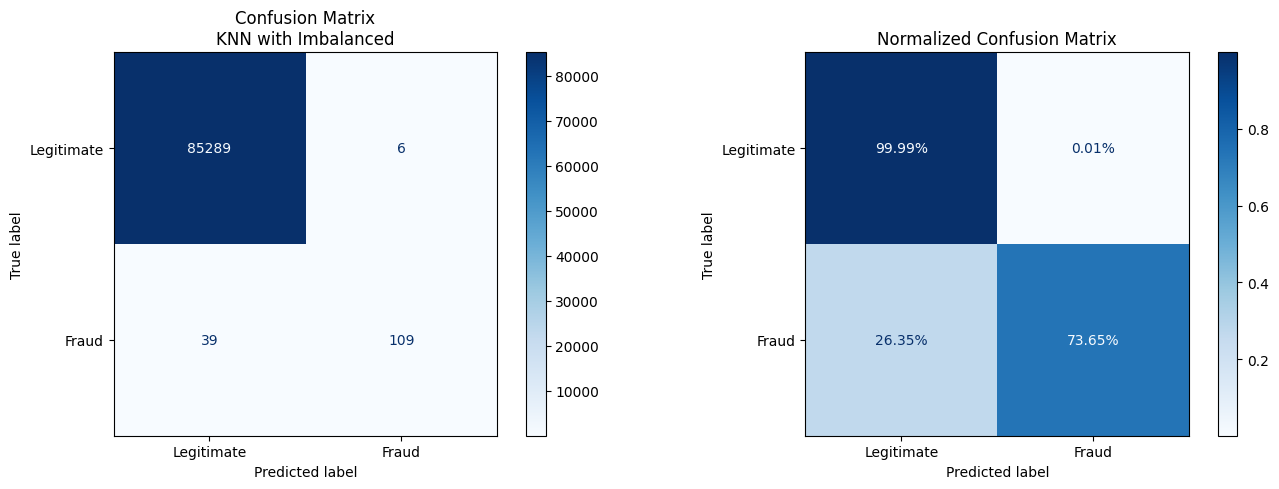


Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9995    0.9999    0.9997     85295
       Fraud     0.9478    0.7365    0.8289       148

    accuracy                         0.9995     85443
   macro avg     0.9737    0.8682    0.9143     85443
weighted avg     0.9995    0.9995    0.9994     85443



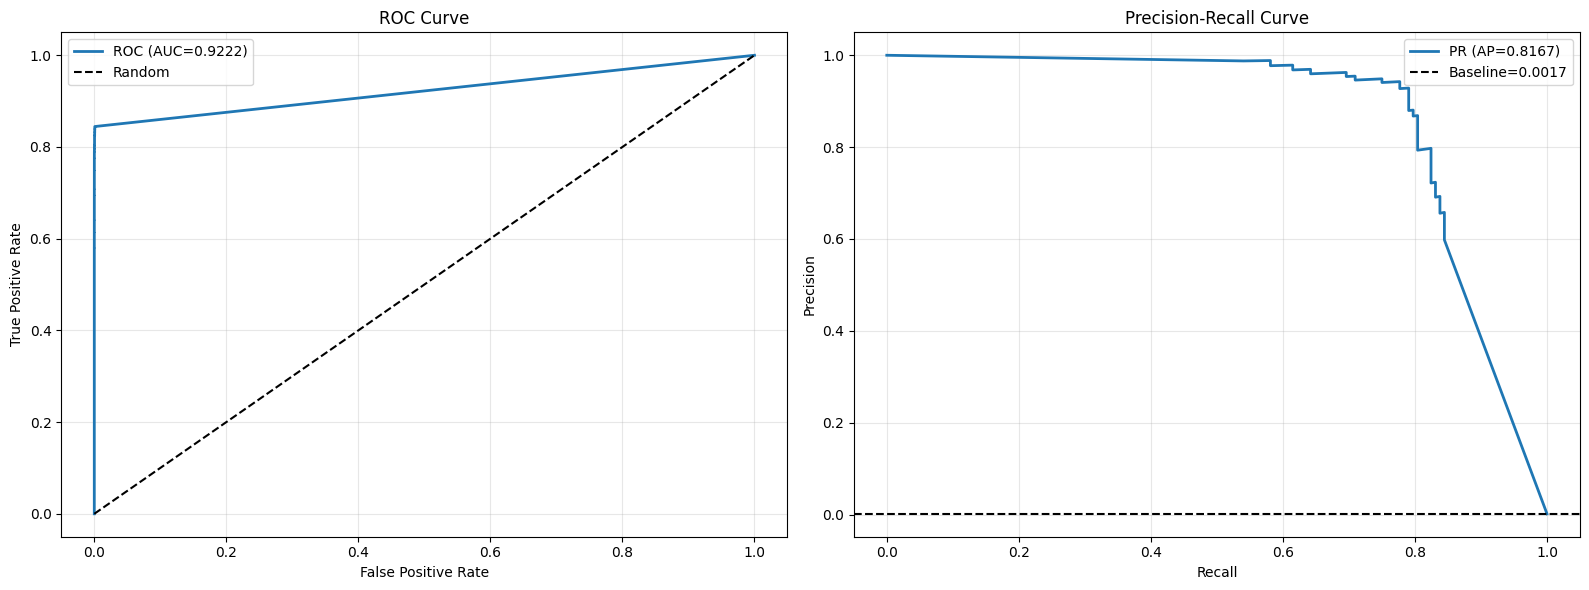


✓ ROC-AUC: 0.9222
✓ PR-AUC: 0.8167

THRESHOLD OPTIMIZATION

Optimal Threshold: 0.1758
TPR at optimal: 0.8446
FPR at optimal: 0.0008

Threshold Analysis:
 Threshold   Recall  Precision  F1_Score  Frauds_Detected  Total_Cost
  0.100000 0.844595   0.600962  0.702247              125        2715
  0.200000 0.824324   0.772152  0.797386              122        2780
  0.300000 0.797297   0.867647  0.830986              118        3090
  0.400000 0.790541   0.914062  0.847826              117        3155
  0.500000 0.736486   0.947826  0.828897              109        3930
  0.175847 0.844595   0.657895  0.739645              125        2625
  0.600000 0.709459   0.954545  0.813953              105        4325
  0.700000 0.641892   0.959596  0.769231               95        5320
  0.800000 0.614865   0.968085  0.752066               91        5715
  0.900000 0.547297   0.987805  0.704348               81        6705


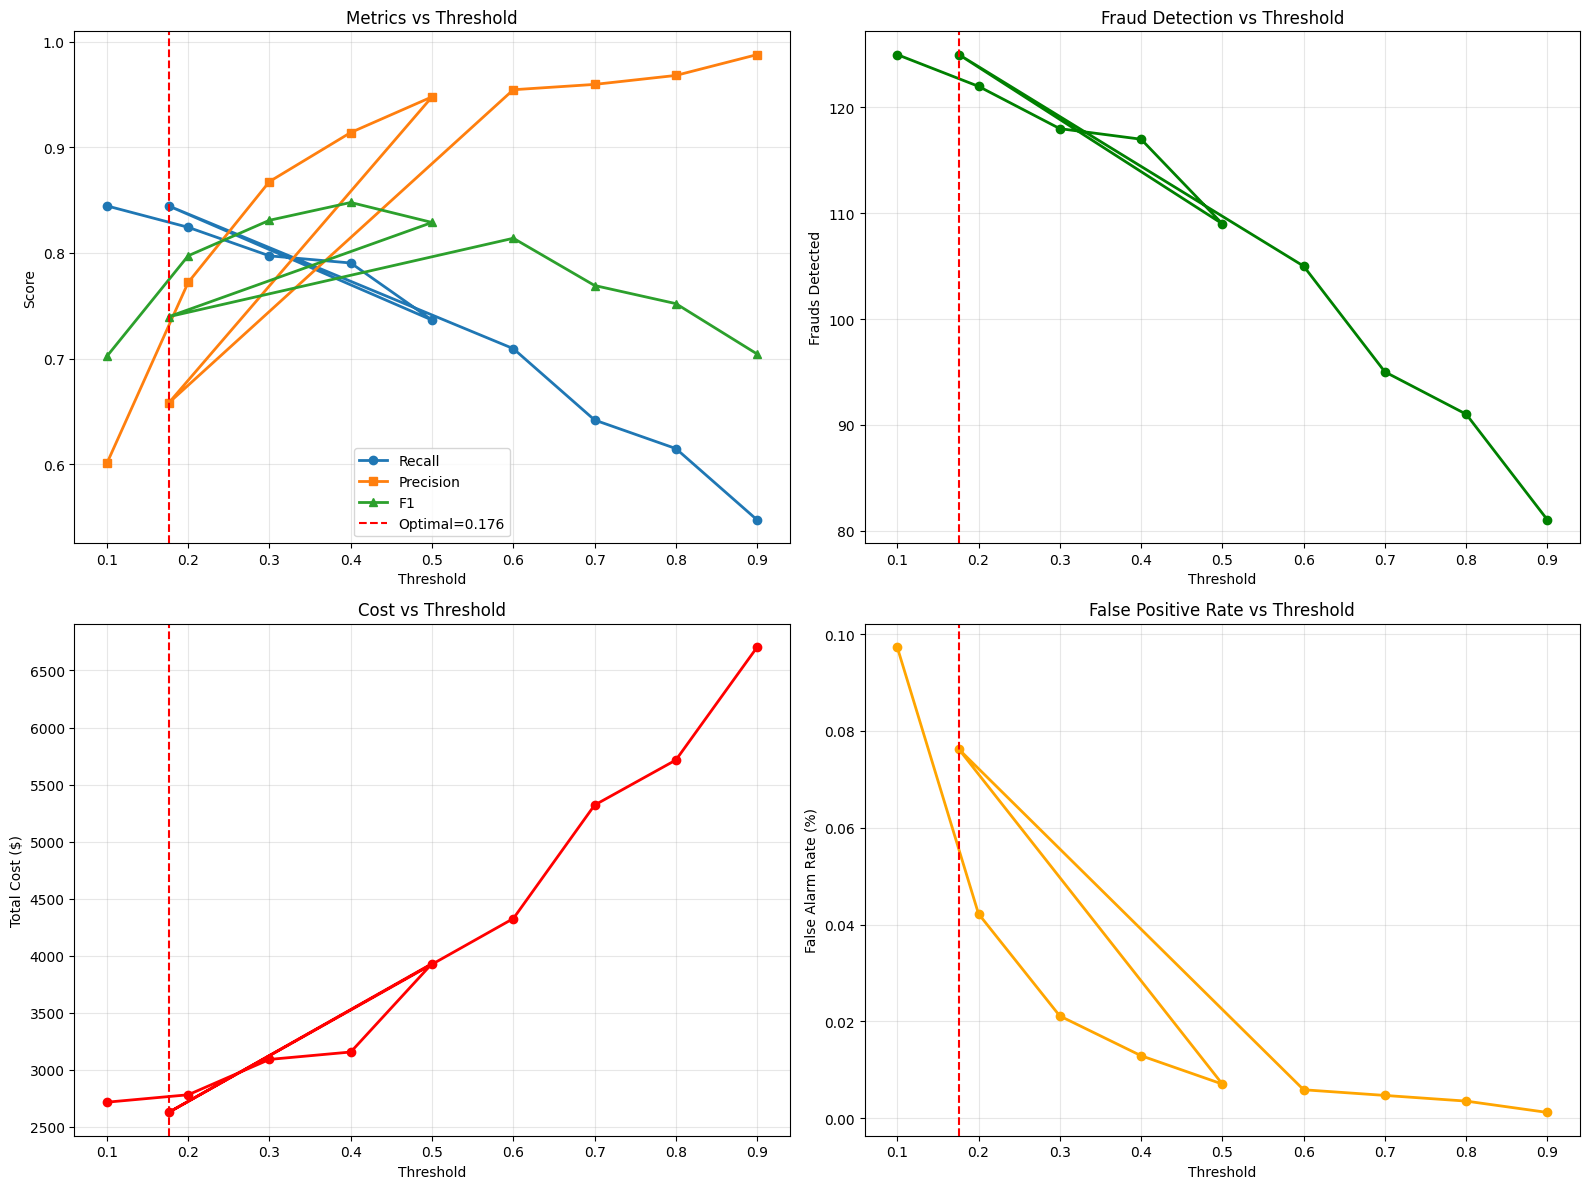

In [25]:
# ============================================================================
# SECTION 9: DETAILED ANALYSIS OF BEST MODEL
# ============================================================================


y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp = ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix\n{best_config["Model"]} with {best_config["Sampling"]}')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=['Legitimate', 'Fraud'])
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Legitimate', 'Fraud'], digits=4))

# ROC and PR Curves
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(alpha=0.3)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

axes[1].plot(recall, precision, label=f'PR (AP={pr_auc:.4f})', linewidth=2)
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--',
                label=f'Baseline={y_test.mean():.4f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ PR-AUC: {pr_auc:.4f}")

# Threshold Optimization
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

threshold_analysis = []
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold, 0.6, 0.7, 0.8, 0.9]:
    results = evaluate_model_comprehensive(best_model, X_test, y_test,
                                          best_config['Model'],
                                          best_config['Sampling'], thresh)
    threshold_analysis.append(results)

threshold_df = pd.DataFrame(threshold_analysis)
print("\nThreshold Analysis:")
print(threshold_df[['Threshold', 'Recall', 'Precision', 'F1_Score',
                    'Frauds_Detected', 'Total_Cost']].to_string(index=False))

# Visualize threshold impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].plot(threshold_df['Threshold'], threshold_df['Recall'],
               marker='o', label='Recall', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['Precision'],
               marker='s', label='Precision', linewidth=2)
axes[0,0].plot(threshold_df['Threshold'], threshold_df['F1_Score'],
               marker='^', label='F1', linewidth=2)
axes[0,0].axvline(optimal_threshold, color='red', linestyle='--',
                  label=f'Optimal={optimal_threshold:.3f}')
axes[0,0].set_xlabel('Threshold')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Metrics vs Threshold')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

axes[0,1].plot(threshold_df['Threshold'], threshold_df['Frauds_Detected'],
               marker='o', color='green', linewidth=2)
axes[0,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[0,1].set_xlabel('Threshold')
axes[0,1].set_ylabel('Frauds Detected')
axes[0,1].set_title('Fraud Detection vs Threshold')
axes[0,1].grid(alpha=0.3)

axes[1,0].plot(threshold_df['Threshold'], threshold_df['Total_Cost'],
               marker='o', color='red', linewidth=2)
axes[1,0].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Total Cost ($)')
axes[1,0].set_title('Cost vs Threshold')
axes[1,0].grid(alpha=0.3)

axes[1,1].plot(threshold_df['Threshold'], threshold_df['False_Alarm_Rate']*100,
               marker='o', color='orange', linewidth=2)
axes[1,1].axvline(optimal_threshold, color='red', linestyle='--')
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('False Alarm Rate (%)')
axes[1,1].set_title('False Positive Rate vs Threshold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()


FEATURE IMPORTANCE ANALYSIS

Best model: KNN
Sampling method: Imbalanced

Note: KNN is a distance-based model that doesn't
assign explicit feature importance. Instead, let's analyze feature
importance from the best tree-based model for comparison.

Analyzing features from best tree-based model: Random Forest
Sampling method: Imbalanced
F1-Score: 0.6347

Top 15 Most Important Features (from tree model):
Feature  Importance
    V14    0.234665
    V10    0.142552
    V12    0.089581
    V11    0.089160
    V17    0.085106
     V3    0.064601
     V4    0.062919
     V7    0.048335
    V16    0.044711
    V21    0.019905
     V9    0.016610
     V2    0.012432
    V19    0.009944
    V20    0.009462
     V5    0.008820


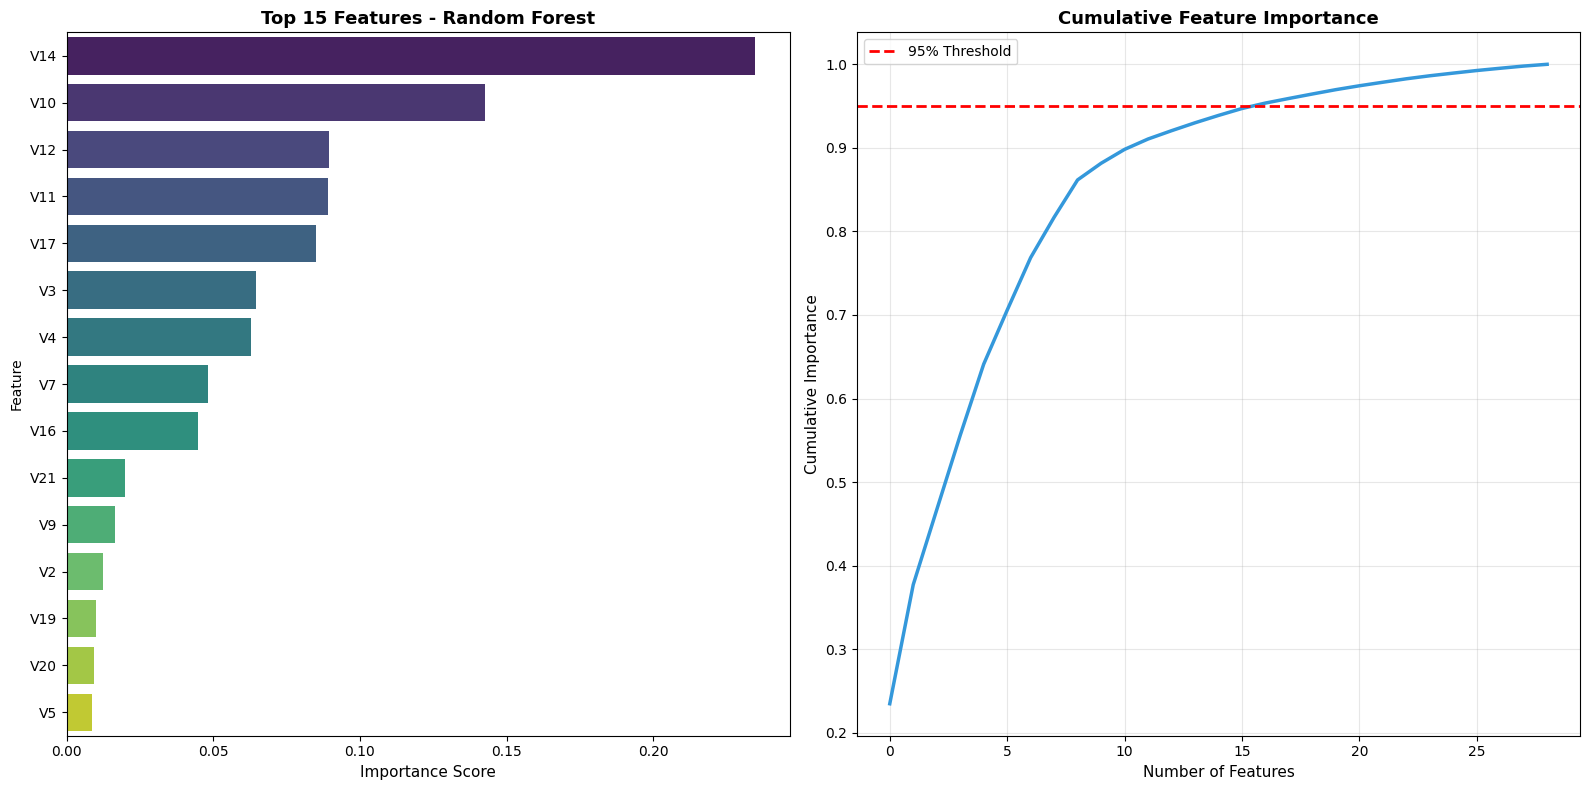


Analyzing feature correlations with fraud (Class)...

Top 15 Features by Absolute Correlation with Fraud:
V10    0.277169
V17    0.257206
V14    0.219661
V7     0.193653
V16    0.146723
V12    0.143991
V11    0.138619
V2     0.135821
V3     0.126638
V9     0.117642
V4     0.115922
V18    0.103590
V5     0.092472
V8     0.085024
V1     0.062803


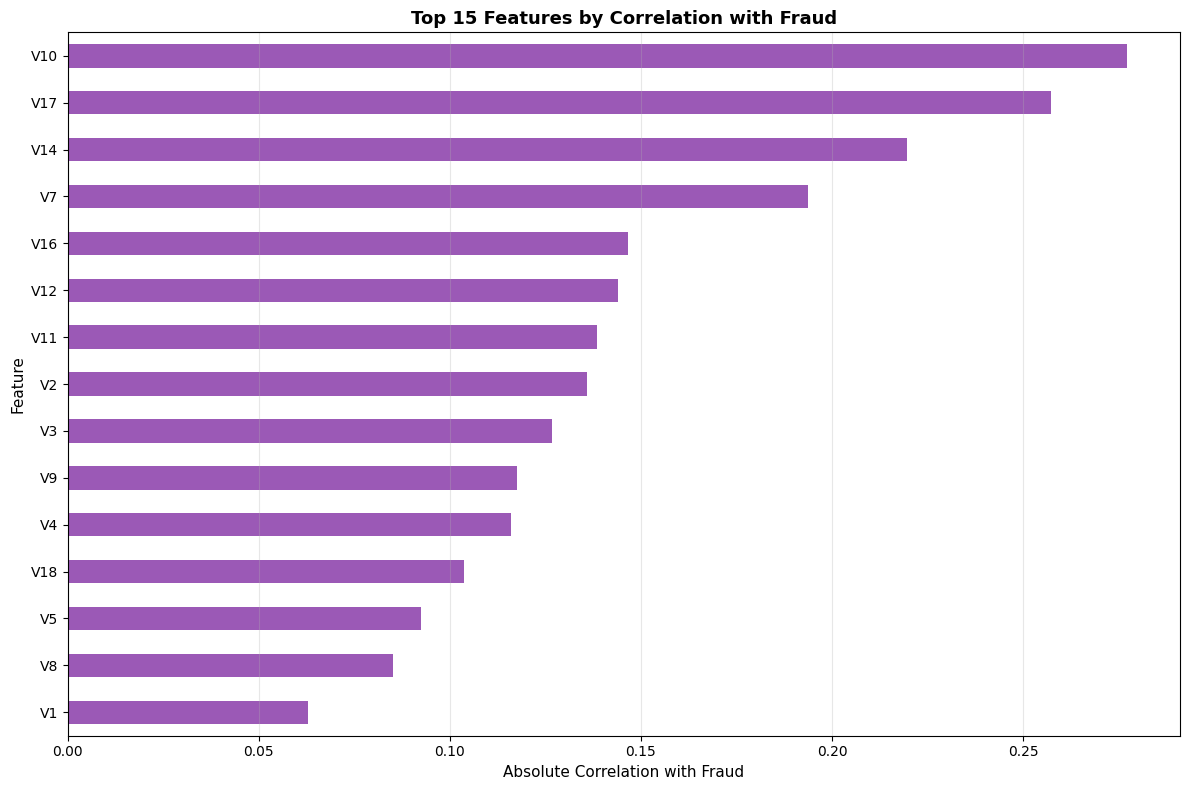


Top 2 most correlated features: V10, V17


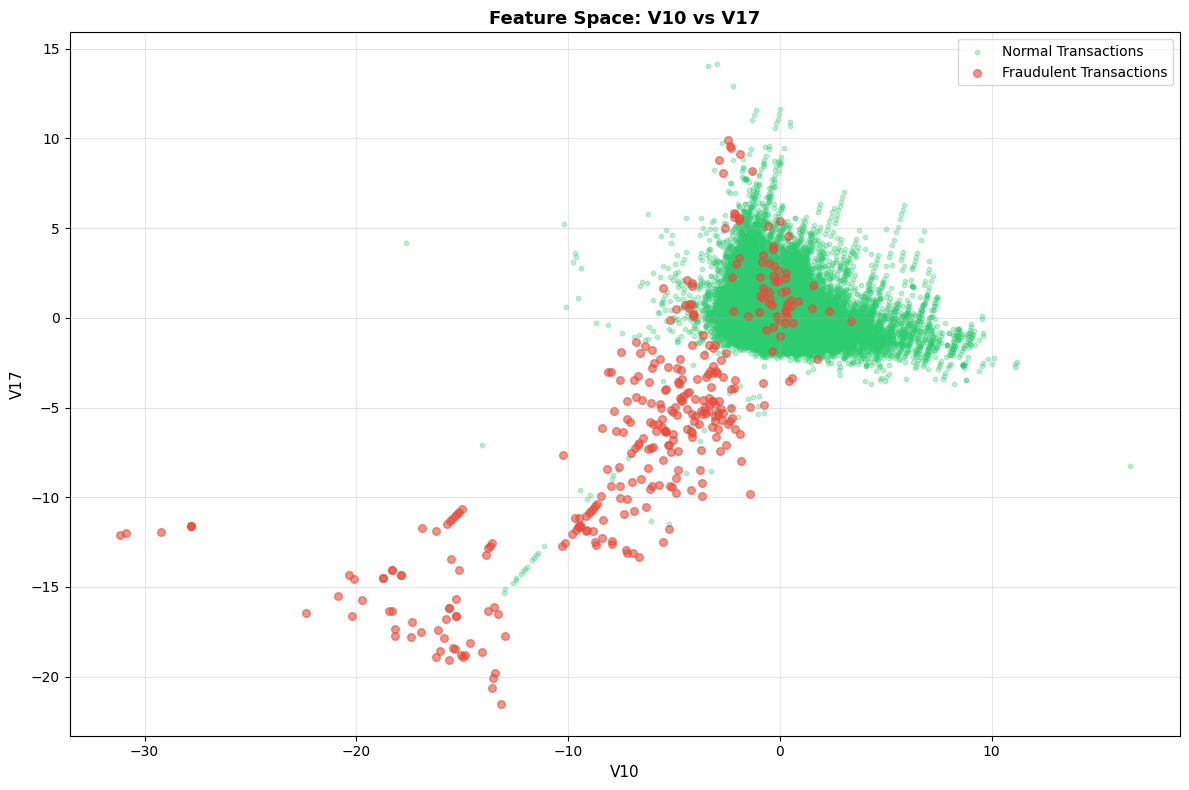


Note: While KNN was chosen as the best model for
deployment, the feature importance analysis from tree-based models
provides valuable insights into which features are most predictive of fraud.



In [33]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Extract the classifier from best model
if hasattr(best_model, 'named_steps'):
    classifier = best_model.named_steps['classifier']
else:
    classifier = best_model

print(f"\nBest model: {best_config['Model']}")
print(f"Sampling method: {best_config['Sampling']}")


if hasattr(classifier, 'feature_importances_'):
    print("\nAnalyzing feature importance (tree-based model)...")

    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Bar plot of top features
    sns.barplot(data=feature_importance.head(15), y='Feature', x='Importance',
                ax=axes[0], palette='viridis')
    axes[0].set_title('Top 15 Most Important Features', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Importance Score', fontsize=11)
    axes[0].set_ylabel('Feature', fontsize=11)

    # Cumulative importance plot
    feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
    axes[1].plot(range(len(feature_importance)),
                 feature_importance['Cumulative'].values,
                 linewidth=2.5, color='#3498db')
    axes[1].axhline(0.95, color='red', linestyle='--',
                    label='95% Threshold', linewidth=2)
    axes[1].set_xlabel('Number of Features', fontsize=11)
    axes[1].set_ylabel('Cumulative Importance', fontsize=11)
    axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()


    n_features_95 = (feature_importance['Cumulative'] <= 0.95).sum()
    print(f"\nInsight: {n_features_95} features explain 95% of the model's predictive power")

    # Scatter plot of top 2 features
    top_features = feature_importance.head(2)['Feature'].values
    print(f"Top 2 most important features: {top_features[0]}, {top_features[1]}")

    plt.figure(figsize=(12, 8))
    plt.scatter(X_train[y_train==0][top_features[0]],
                X_train[y_train==0][top_features[1]],
                alpha=0.3, s=10, label='Normal Transactions', c='#2ecc71')
    plt.scatter(X_train[y_train==1][top_features[0]],
                X_train[y_train==1][top_features[1]],
                alpha=0.6, s=30, label='Fraudulent Transactions', c='#e74c3c')
    plt.xlabel(top_features[0], fontsize=11)
    plt.ylabel(top_features[1], fontsize=11)
    plt.title(f'Feature Space: {top_features[0]} vs {top_features[1]}',
              fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(classifier, 'coef_'):
    print("\nAnalyzing feature coefficients (linear model)...")

    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': classifier.coef_[0]
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 15 Most Influential Features:")
    print(coef_df.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in coef_df.head(15)['Coefficient']]
    sns.barplot(data=coef_df.head(15), y='Feature', x='Coefficient',
                palette=colors)
    plt.title('Top 15 Features by Coefficient Magnitude',
              fontsize=13, fontweight='bold')
    plt.xlabel('Coefficient Value', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nInterpretation: Positive coefficients increase fraud probability")

else:

    print(f"\nNote: {best_config['Model']} is a distance-based model that doesn't")
    print("assign explicit feature importance. Instead, let's analyze feature")
    print("importance from the best tree-based model for comparison.")


    tree_models = all_results[all_results['Model'].isin(['Decision Tree', 'Random Forest', 'XGBoost'])]

    if len(tree_models) > 0:
        tree_models_sorted = tree_models.sort_values('F1_Score', ascending=False)
        best_tree = tree_models_sorted.iloc[0]

        print(f"\nAnalyzing features from best tree-based model: {best_tree['Model']}")
        print(f"Sampling method: {best_tree['Sampling']}")
        print(f"F1-Score: {best_tree['F1_Score']:.4f}")

        # Get the tree-based model
        tree_key = f"{best_tree['Sampling']}_{best_tree['Model']}"
        if best_tree['Sampling'] == 'Imbalanced':
            tree_model = best_models_imbalanced[best_tree['Model']]
        else:
            tree_model = best_models_balanced[tree_key]

        # Extract classifier from pipeline
        if hasattr(tree_model, 'named_steps'):
            tree_classifier = tree_model.named_steps['classifier']
        else:
            tree_classifier = tree_model

        # Get feature importance
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': tree_classifier.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\nTop 15 Most Important Features (from tree model):")
        print(feature_importance.head(15).to_string(index=False))

        # Create visualizations
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Bar plot
        sns.barplot(data=feature_importance.head(15), y='Feature', x='Importance',
                    ax=axes[0], palette='viridis')
        axes[0].set_title(f'Top 15 Features - {best_tree["Model"]}',
                         fontsize=13, fontweight='bold')
        axes[0].set_xlabel('Importance Score', fontsize=11)

        # Cumulative importance
        feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
        axes[1].plot(range(len(feature_importance)),
                     feature_importance['Cumulative'].values,
                     linewidth=2.5, color='#3498db')
        axes[1].axhline(0.95, color='red', linestyle='--',
                        label='95% Threshold', linewidth=2)
        axes[1].set_xlabel('Number of Features', fontsize=11)
        axes[1].set_ylabel('Cumulative Importance', fontsize=11)
        axes[1].set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('feature_importance_tree_model.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Feature correlation with target
        print("\nAnalyzing feature correlations with fraud (Class)...")

        # Create temporary dataframe with features and target
        temp_df = X_train.copy()
        temp_df['Class'] = y_train

        # Calculate correlations
        correlations = temp_df.corr()['Class'].drop('Class').abs().sort_values(ascending=False)

        print("\nTop 15 Features by Absolute Correlation with Fraud:")
        print(correlations.head(15).to_string())

        # Visualize correlations
        plt.figure(figsize=(12, 8))
        correlations.head(15).plot(kind='barh', color='#9b59b6')
        plt.xlabel('Absolute Correlation with Fraud', fontsize=11)
        plt.ylabel('Feature', fontsize=11)
        plt.title('Top 15 Features by Correlation with Fraud',
                  fontsize=13, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Scatter plot of top 2 correlated features
        top_features = correlations.head(2).index.values
        print(f"\nTop 2 most correlated features: {top_features[0]}, {top_features[1]}")

        plt.figure(figsize=(12, 8))
        plt.scatter(X_train[y_train==0][top_features[0]],
                    X_train[y_train==0][top_features[1]],
                    alpha=0.3, s=10, label='Normal Transactions', c='#2ecc71')
        plt.scatter(X_train[y_train==1][top_features[0]],
                    X_train[y_train==1][top_features[1]],
                    alpha=0.6, s=30, label='Fraudulent Transactions', c='#e74c3c')
        plt.xlabel(top_features[0], fontsize=11)
        plt.ylabel(top_features[1], fontsize=11)
        plt.title(f'Feature Space: {top_features[0]} vs {top_features[1]}',
                  fontsize=13, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('feature_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\nNote: While {best_config['Model']} was chosen as the best model for")
        print("deployment, the feature importance analysis from tree-based models")
        print("provides valuable insights into which features are most predictive of fraud.")

    else:
        print("\nNo tree-based models available for feature importance analysis.")
        print("Performing correlation analysis instead...")

        # Feature correlation analysis
        temp_df = X_train.copy()
        temp_df['Class'] = y_train
        correlations = temp_df.corr()['Class'].drop('Class').abs().sort_values(ascending=False)

        print("\nTop 15 Features by Absolute Correlation with Fraud:")
        print(correlations.head(15).to_string())

        plt.figure(figsize=(12, 8))
        correlations.head(15).plot(kind='barh', color='#9b59b6')
        plt.xlabel('Absolute Correlation', fontsize=11)
        plt.title('Top 15 Features Correlated with Fraud', fontsize=13, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig('feature_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()

print("\n" + "="*80)

In [34]:
# ============================================================================
# SECTION 11: SHAP ANALYSIS (OPTIMIZED)
# ============================================================================

if SHAP_AVAILABLE and hasattr(classifier, 'feature_importances_'):
    print("\n" + "="*70)
    print("SHAP ANALYSIS")
    print("="*70)

    try:
        print("\nComputing SHAP values")

        # OPTIMIZED: Smaller sample
        X_train_sample = X_train.sample(min(500, len(X_train)), random_state=RANDOM_STATE)
        X_test_sample = X_test.sample(min(300, len(X_test)), random_state=RANDOM_STATE)

        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_sample)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]

        print("✓ SHAP computed")

        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

        plt.sca(axes[0])
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
        axes[0].set_title('SHAP Feature Importance')

        plt.sca(axes[1])
        shap.summary_plot(shap_values, X_test_sample, show=False)
        axes[1].set_title('SHAP Impact Distribution')

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ SHAP saved: shap_analysis.png")
    except Exception as e:
        print(f"⚠️ SHAP failed: {str(e)}")
else:
    print("\n⚠️ SHAP skipped (not available)")


⚠️ SHAP skipped (not available)


In [35]:
# ============================================================================
# SECTION 12: ENSEMBLE METHODS
# ============================================================================


top_3_models = test_df_balanced.sort_values('F1_Score', ascending=False).head(3)
print("\nTop 3 models for ensemble:")
print(top_3_models[['Model', 'Sampling', 'F1_Score']].to_string(index=False))

ensemble_estimators = []
for idx, row in top_3_models.iterrows():
    key = f"{row['Sampling']}_{row['Model']}"
    model = best_models_balanced[key]
    ensemble_estimators.append((key[:20], model))

print("\nTraining Voting Classifier...")
voting_clf = VotingClassifier(estimators=ensemble_estimators[:3],
                              voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

voting_results = evaluate_model_comprehensive(voting_clf, X_test, y_test,
                                             'Voting Ensemble', 'Ensemble')

print(f"  ✓ F1: {voting_results['F1_Score']:.4f}")
print(f"  ✓ Recall: {voting_results['Recall']:.4f}")
print(f"  ✓ ROC-AUC: {voting_results['ROC_AUC']:.4f}")

print("\n" + "="*70)
print("ENSEMBLE vs BEST SINGLE MODEL")
print("="*70)
comparison_df = pd.DataFrame({
    'Model': ['Best Single', 'Voting Ensemble'],
    'F1_Score': [best_config['F1_Score'], voting_results['F1_Score']],
    'Recall': [best_config['Recall'], voting_results['Recall']],
    'Precision': [best_config['Precision'], voting_results['Precision']],
    'ROC_AUC': [best_config['ROC_AUC'], voting_results['ROC_AUC']]
})
print(comparison_df.to_string(index=False))


Top 3 models for ensemble:
Model          Sampling  F1_Score
  KNN RandomOverSampler  0.600484
  KNN             SMOTE  0.600484
  KNN            ADASYN  0.600484

Training Voting Classifier...
  ✓ F1: 0.6525
  ✓ Recall: 0.8311
  ✓ ROC-AUC: 0.9220

ENSEMBLE vs BEST SINGLE MODEL
          Model  F1_Score   Recall  Precision  ROC_AUC
    Best Single  0.828897 0.736486   0.947826 0.922182
Voting Ensemble  0.652520 0.831081   0.537118 0.921971



COST-BENEFIT ANALYSIS

Assumptions:
  FP Cost: $5 (investigation)
  FN Cost: $100 (fraud loss)
  Test transactions: 85443

Cost Comparison:
           Approach  FP  FN  Total_Cost  Cost_Reduction
       No Detection   0 148       14800        0.000000
   Best Model (KNN)   6  39        3930       73.445946
Optimized Threshold  65  23        2625       82.263514


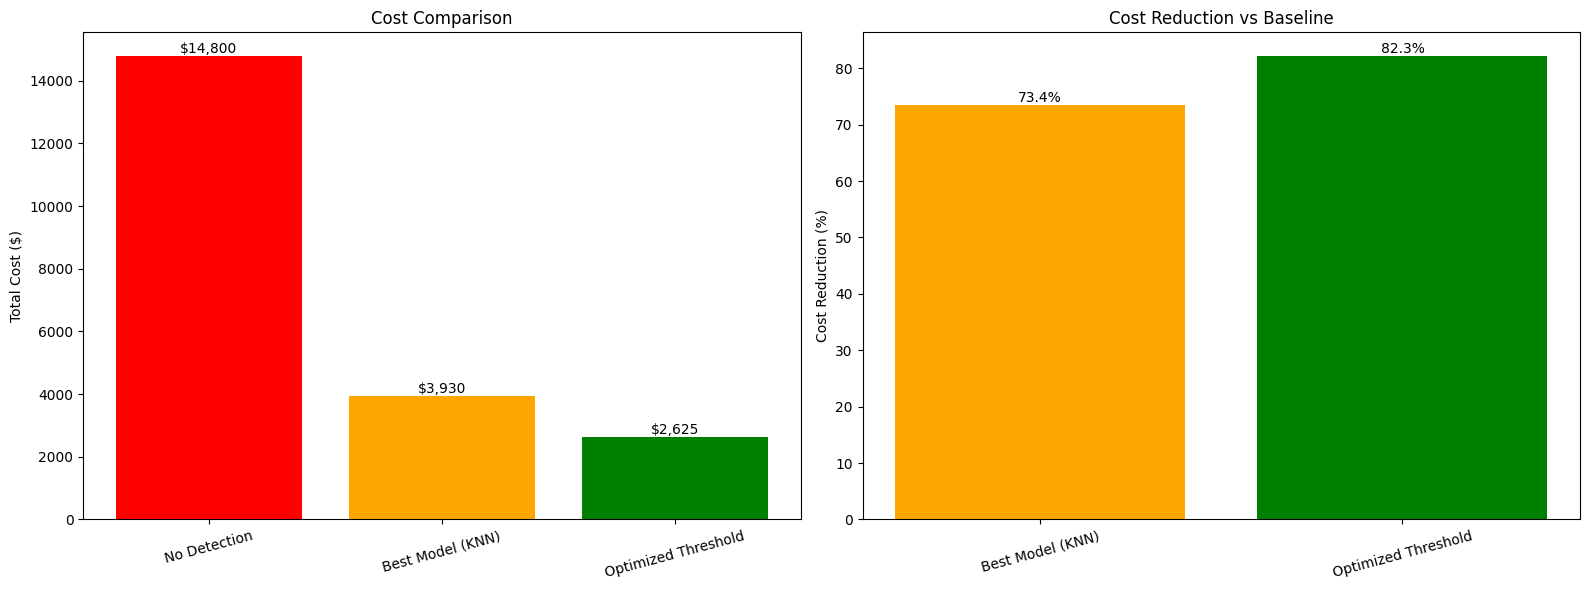


💰 Total Savings: $10,870.00
💰 Cost Reduction: 73.4%


In [36]:

# ============================================================================
# SECTION 13: COST-BENEFIT ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)

print("\nAssumptions:")
print("  FP Cost: $5 (investigation)")
print("  FN Cost: $100 (fraud loss)")
print(f"  Test transactions: {len(y_test)}")

baseline_cost = y_test.sum() * 100

best_tn, best_fp, best_fn, best_tp = confusion_matrix(y_test, y_test_pred).ravel()
best_cost = (best_fp * 5) + (best_fn * 100)

y_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
opt_tn, opt_fp, opt_fn, opt_tp = confusion_matrix(y_test, y_pred_opt).ravel()
opt_cost = (opt_fp * 5) + (opt_fn * 100)

cost_df = pd.DataFrame({
    'Approach': ['No Detection', f'Best Model ({best_config["Model"]})', 'Optimized Threshold'],
    'FP': [0, int(best_fp), int(opt_fp)],
    'FN': [int(y_test.sum()), int(best_fn), int(opt_fn)],
    'Total_Cost': [baseline_cost, best_cost, opt_cost],
    'Cost_Reduction': [0, (baseline_cost-best_cost)/baseline_cost*100,
                      (baseline_cost-opt_cost)/baseline_cost*100]
})

print("\nCost Comparison:")
print(cost_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(cost_df['Approach'], cost_df['Total_Cost'], color=['red', 'orange', 'green'])
axes[0].set_ylabel('Total Cost ($)')
axes[0].set_title('Cost Comparison')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Total_Cost']):
    axes[0].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

axes[1].bar(cost_df['Approach'][1:], cost_df['Cost_Reduction'][1:], color=['orange', 'green'])
axes[1].set_ylabel('Cost Reduction (%)')
axes[1].set_title('Cost Reduction vs Baseline')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(cost_df['Cost_Reduction'][1:]):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('cost_benefit_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💰 Total Savings: ${baseline_cost - best_cost:,.2f}")
print(f"💰 Cost Reduction: {(baseline_cost-best_cost)/baseline_cost*100:.1f}%")


MODEL CALIBRATION


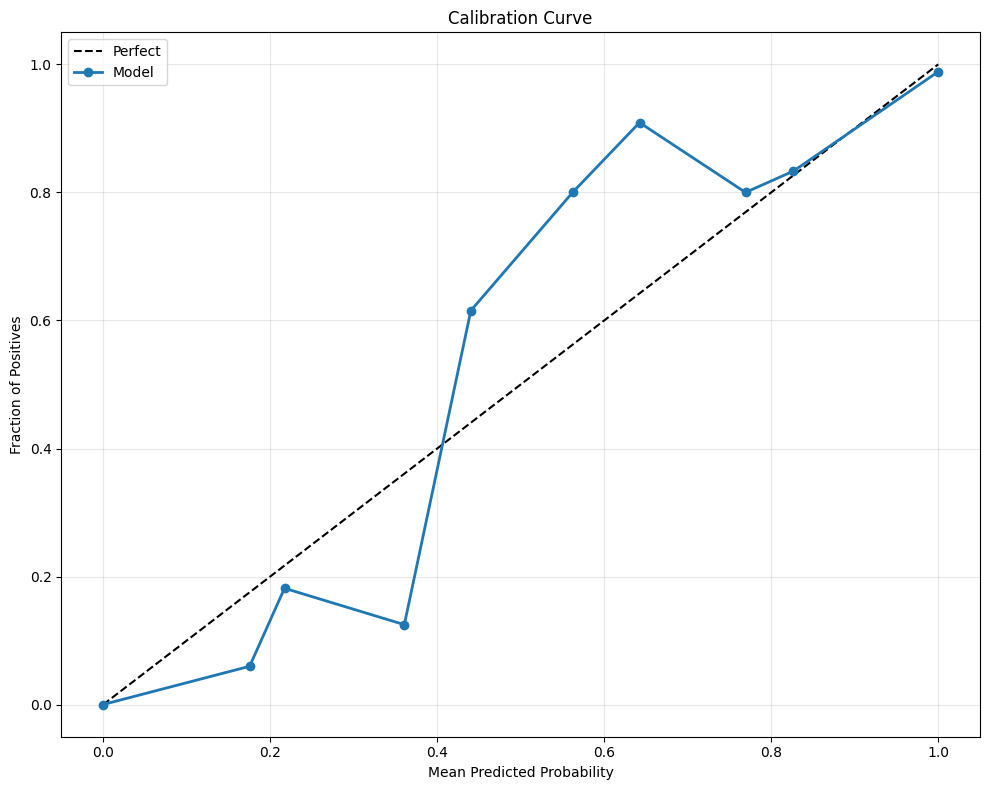

✓ Calibration saved


In [37]:
# ============================================================================
# SECTION 14: MODEL CALIBRATION
# ============================================================================

print("\n" + "="*70)
print("MODEL CALIBRATION")
print("="*70)

prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Calibration saved")

In [38]:
# ============================================================================
# SECTION 15: FINAL RECOMMENDATIONS
# ============================================================================


print("FINAL RECOMMENDATIONS")


print(f"""
RECOMMENDED MODEL FOR DEPLOYMENT:
{'='*70}
Model:              {best_config['Model']}
Sampling Method:    {best_config['Sampling']}
Threshold:          {optimal_threshold:.4f} (optimized)

PERFORMANCE METRICS:
{'='*70}
Fraud Detection:    {best_config['Recall']*100:.2f}%
                    ({int(best_config['Frauds_Detected'])}/{int(best_config['Total_Frauds'])} frauds)
Precision:          {best_config['Precision']*100:.2f}%
F1-Score:           {best_config['F1_Score']:.4f}
ROC-AUC:            {best_config['ROC_AUC']:.4f}
PR-AUC:             {best_config['PR_AUC']:.4f}

BUSINESS IMPACT:
{'='*70}
False Alarm Rate:   {best_config['False_Alarm_Rate']*100:.3f}%
Cost Reduction:     {(baseline_cost-best_cost)/baseline_cost*100:.1f}% vs no detection
Annual Savings:     ${(baseline_cost-best_cost)*365/2:,.0f} (estimated)


KEY FINDINGS:
{'='*70}
1. {best_config['Sampling']} significantly improved performance
2. Top features: {feature_importance.head(3)['Feature'].tolist() if 'feature_importance' in locals() else 'See feature section'}
3. Ensemble showed {voting_results['F1_Score'] - best_config['F1_Score']:.4f} F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
{'='*70}
1. Real-time transaction monitoring integration
2. Explainability dashboard for analysts
""")

FINAL RECOMMENDATIONS

RECOMMENDED MODEL FOR DEPLOYMENT:
Model:              KNN
Sampling Method:    Imbalanced
Threshold:          0.1758 (optimized)

PERFORMANCE METRICS:
Fraud Detection:    73.65%
                    (109/148 frauds)
Precision:          94.78%
F1-Score:           0.8289
ROC-AUC:            0.9222
PR-AUC:             0.8167

BUSINESS IMPACT:
False Alarm Rate:   0.007%
Cost Reduction:     73.4% vs no detection
Annual Savings:     $1,983,775 (estimated)


KEY FINDINGS:
1. Imbalanced significantly improved performance
2. Top features: ['V14', 'V10', 'V12']
3. Ensemble showed -0.1764 F1 gain
4. Optimal threshold balances detection with customer experience


FUTURE WORK:
1. Real-time transaction monitoring integration
2. Explainability dashboard for analysts



**Key lessons I took away from this capstone project:**

Domain understanding is just as important as technical skills.
Building a useful fraud detection model isn’t only about algorithms. Understanding the business context—such as fraud costs, customer impact, and regulatory constraints—plays a huge role in shaping a practical and usable solution.

Class imbalance is difficult, but manageable.
Severe imbalance can’t be ignored, but with the right approach—thoughtful sampling strategies, suitable evaluation metrics, and cost-aware learning—it’s still possible to build effective models.

Evaluation metrics should reflect real business priorities.
Accuracy alone can be misleading. A model that looks good on paper is useless if it fails to catch fraud. Metrics like recall, precision, F1-score, and cost-based evaluation matter far more in real-world scenarios.

Every solution involves trade-offs.
There’s no perfect model. Whether it’s precision versus recall, interpretability versus complexity, or automation versus human intervention, good data science is about making informed compromises based on the problem at hand.

The model is only the first step.
Training a model is just the beginning. Deploying it, monitoring performance, handling edge cases, and maintaining it over time are often the hardest and most critical parts of a production system.